BMW data cleaning and randominzation for export to csvs for MIT-NorthStar project

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import pandas as pd
import numpy as np
import calendar
import random
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import itertools
from statistics import stdev 
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

#make sure in HR environment
import argparse
import hashlib
from Crypto.Cipher import AES
from Crypto import Random
from datetime import datetime
#import pandasql as ps

#from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn import tree

# relevant tensorflow imports:

from sklearn.preprocessing import Imputer
import tensorflow as tf
from tensorflow import keras
from sklearn.utils import shuffle
# from imblearn.over_sampling import RandomOverSampler
import copy

random.seed(1)
np.random.seed(1)

/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passi

### all data from oracle connections to TS_INFO table and actuals punch data stored in HIVE

Used bmw_data_cleaning.py file to generate csvs for use here

In [2]:
df_bmw = pd.read_csv("bmw_demo.csv",
                     index_col=[0])

#cost-center headcount, gender counts, and avg tenure per month/shift/cc
cc_grp = pd.read_csv("cc_grp.csv",
                    index_col=[0])


#daily quality for assembly halls 50 and 52
quality_daily_hall = pd.read_csv("quality_daily_hall.csv")

actuals = pd.read_csv("actual_demo.csv",
                      index_col=[0])

plant_totals = pd.read_csv("plant_totals.csv")

#bmw attendance points

bmw_points = pd.read_csv("bmw_points_200114.csv")

df_ejsi = pd.read_csv("df_ejsi.csv")
pd.options.display.max_columns = None

In [3]:
plant_totals = plant_totals[plant_totals.date_month> "2018-01"]

In [4]:
df_ejsi = df_ejsi[df_ejsi.start_dt > "2019-01-01"]
df_bmw = df_bmw[df_bmw.birth_year<2010]

In [5]:
df_bmw.birth_year.max()

2001

In [6]:
df_bmw[df_bmw.birth_year>2009]

,start_date,end_date,cost_center_name,org_unit,dept,badge,status,ee_type,ta_admin_num,ta_admin_name,birth_year,gender,zip_code_type,zip_code,city,ws_rule,ws_text,daily_hours,race,last_date_worked,start_date_month,end_date_month,first_punch_cost_center,cost_center_orig,cost_center,ejsi_cc,first_ejsi_start_dt,first_ejsi_proc_desc,first_ejsi_cost_center,hall,tenure_yrs,age_at_hire,shift


In [7]:
quality_daily_hall = quality_daily_hall[quality_daily_hall.f1_date>'2018-01-01']
quality_daily_hall = quality_daily_hall.drop(quality_daily_hall.columns[0], axis=1)
quality_daily_hall.head()

,f1_date,shift,hall,volume,repair_minutes,defect_date,count_non_dp_vins_hall,rmu_hall,dpu_hall,dp_f1_hall
2592,2018-01-02,A,50,259.0,15028.5,2018-01-02,186.0,58.025097,0.718147,0.281853
2593,2018-01-02,A,52,279.0,19112.0,2018-01-02,284.0,68.501792,1.017921,-0.017921
2594,2018-01-02,B,50,323.0,10317.0,2018-01-02,255.0,31.941176,0.789474,0.210526
2595,2018-01-02,B,52,311.0,15299.0,2018-01-02,363.0,49.192926,1.167203,-0.167203
2596,2018-01-03,A,50,305.0,13044.0,2018-01-03,186.0,42.767213,0.609836,0.390164


In [8]:
# pd.crosstab(df_bmw['race'], df_bmw['gender'])

In [9]:
bmw_points.head()

,badge,name,cost_center,att_date,att_code,att_desc,hours
0,124,Tim G Howe,2666,10/10/19,9000,Daily Occurrences,8.0
1,124,Tim G Howe,2666,10/24/19,9000,Daily Occurrences,4.0
2,124,Tim G Howe,2666,10/25/19,9000,Daily Occurrences,4.0
3,139,Philip A Richards,2830,1/13/20,9000,Daily Occurrences,4.0
4,298,Edward L Kearse,1856,11/6/19,9000,Daily Occurrences,4.0


## Predict who will leave in next 30 days

For those who have already left, get the averages for the month before they left
For those still active, get averages for the month before the cutoff

In [10]:
#get the last month they were active

#df_bmw['last_date_worked'] = pd.to_datetime(np.where(df_bmw['status']=='Terminted', df_bmw['end_date'],
#                                      datetime.now().strftime("%Y-%m-%d")))
                                
#df_bmw['last_month_worked'] = df_bmw['last_date_worked'].dt.to_period('M')                             

In [11]:
df_bmw.head()
#last date worked filled into be current date as of 1-15-20

,start_date,end_date,cost_center_name,org_unit,dept,badge,status,ee_type,ta_admin_num,ta_admin_name,birth_year,gender,zip_code_type,zip_code,city,ws_rule,ws_text,daily_hours,race,last_date_worked,start_date_month,end_date_month,first_punch_cost_center,cost_center_orig,cost_center,ejsi_cc,first_ejsi_start_dt,first_ejsi_proc_desc,first_ejsi_cost_center,hall,tenure_yrs,age_at_hire,shift
0,1994-01-04,NaN,SVO,80001887,TX-453,120,Active,Hourly,A27,Todd Hill,1964,Male,Mailing Address,29645.0,Gray Court,APBC,A-Shift Paint App B/C,8,Non-Hispanic/Latino,2020-01-15,1994-01,NaN,1856.0,1856,1856.0,NaN,NaN,NaN,NaN,50.0,26.046575,29.953425,A
1,1994-01-04,2019-10-25,Machine Shop/Gun Sho,80001854,TX-212,124,Retiree,Hourly,NaN,NaN,1954,Male,Mailing Address,29369.0,moore,AICP,A-Shift ICP,8,Non-Hispanic/Latino,2019-10-25,1994-01,2019-10,2666.0,2666,2666.0,NaN,NaN,NaN,NaN,NaN,25.821918,40.178082,A
2,1994-01-04,NaN,Assem. Quality,80000650,TX-40,139,Active,Hourly,Y92,Kyle K Brooks,1970,Male,Mailing Address,29323.0,Chesnee,AFE2,A-Shift Facilities Early,10,Non-Hispanic/Latino,2020-01-15,1994-01,NaN,2830.0,2830,2830.0,NaN,NaN,NaN,NaN,50.0,26.046575,23.953425,A
3,1994-01-04,2019-10-25,Underbody/Steerng Kn,80002975,TX-436,140,Retiree,Hourly,NaN,NaN,1955,Female,Mailing Address,29302.0,Spartanburg,APBC,A-Shift Paint App B/C,8,Non-Hispanic/Latino,2019-10-25,1994-01,2019-10,1807.0,1807,1807.0,NaN,NaN,NaN,NaN,50.0,25.821918,39.178082,A
4,1994-02-21,NaN,ICP,80001886,TX-452,185,Active,Hourly,Y75,Brian Kelly Reynolds,1959,Female,Mailing Address,29681.0,Simpsonville,APBC,A-Shift Paint App B/C,8,Non-Hispanic/Latino,2020-01-15,1994-02,NaN,1900.0,1900,1900.0,NaN,NaN,NaN,NaN,NaN,25.915068,35.084932,A


## get monthly average quality KPIs


In [12]:
cc_grp.head()

#headcount and gender counts already done at month level

,shift,work_date_month,cost_center,headcount_mau_cc,headcount_bmw_cc,total_headcount_cc,count_female_cc,count_male_cc,count_nogender_cc,percentage_female_cc,avg_tenure_cc,avg_tenure_bmw_cc,count_bmw_employees_tenure,avg_tenure_mau_cc,count_mau_employees_tenure,count_hired_mau,count_hired_bmw,count_termianted_bmw,count_termianted_mau
0,A,2018-04,1026.0,67.0,5.0,72.0,22.0,39.0,0.0,0.360656,1.171542,17.191096,4.0,0.066745,57.0,NaN,NaN,NaN,NaN
1,A,2018-04,1317.0,46.0,4.0,50.0,11.0,37.0,0.0,0.229167,2.613918,11.825342,4.0,1.812924,44.0,4.0,NaN,NaN,2.0
2,A,2018-04,1319.0,26.0,4.0,30.0,12.0,36.0,1.0,0.244898,3.764000,10.542009,6.0,2.839726,43.0,NaN,NaN,NaN,1.0
3,A,2018-04,1340.0,33.0,4.0,37.0,7.0,46.0,0.0,0.132075,5.317310,15.943836,6.0,4.016103,47.0,6.0,NaN,NaN,1.0
4,A,2018-04,1341.0,8.0,0.0,8.0,1.0,4.0,0.0,0.200000,9.761644,NaN,NaN,9.761644,5.0,2.0,NaN,NaN,NaN


In [13]:
quality_daily_hall.head()

,f1_date,shift,hall,volume,repair_minutes,defect_date,count_non_dp_vins_hall,rmu_hall,dpu_hall,dp_f1_hall
2592,2018-01-02,A,50,259.0,15028.5,2018-01-02,186.0,58.025097,0.718147,0.281853
2593,2018-01-02,A,52,279.0,19112.0,2018-01-02,284.0,68.501792,1.017921,-0.017921
2594,2018-01-02,B,50,323.0,10317.0,2018-01-02,255.0,31.941176,0.789474,0.210526
2595,2018-01-02,B,52,311.0,15299.0,2018-01-02,363.0,49.192926,1.167203,-0.167203
2596,2018-01-03,A,50,305.0,13044.0,2018-01-03,186.0,42.767213,0.609836,0.390164


In [14]:
quality_daily_hall['f1_month'] = pd.to_datetime(quality_daily_hall['f1_date']).dt.to_period('M')

#sum up all volume created in that month

quality_daily_hall_monthly = quality_daily_hall.groupby([
                                                         'f1_month',
                                                            'shift',
                                                            'hall'],
                                    as_index=False).agg({
                                        'volume':'sum',
                                        'repair_minutes':'sum',
                                        'count_non_dp_vins_hall':'sum'})


quality_daily_hall_monthly['RMU_hall_month'] = quality_daily_hall_monthly['repair_minutes'] / (quality_daily_hall_monthly['volume']).astype('float')
quality_daily_hall_monthly['dpu_hall_month'] = quality_daily_hall_monthly['count_non_dp_vins_hall']/ quality_daily_hall_monthly['volume']

quality_daily_hall_monthly['f1_dp_hall_month'] = (quality_daily_hall_monthly['volume'] - quality_daily_hall_monthly['count_non_dp_vins_hall'])/ quality_daily_hall_monthly['volume']


In [15]:
quality_daily_hall_monthly.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92 entries, 0 to 91
Data columns (total 9 columns):
f1_month                  92 non-null period[M]
shift                     92 non-null object
hall                      92 non-null int64
volume                    92 non-null float64
repair_minutes            92 non-null float64
count_non_dp_vins_hall    92 non-null float64
RMU_hall_month            92 non-null float64
dpu_hall_month            92 non-null float64
f1_dp_hall_month          92 non-null float64
dtypes: float64(6), int64(1), object(1), period[M](1)
memory usage: 7.2+ KB


In [16]:
quality_daily_hall_monthly.head()

,f1_month,shift,hall,volume,repair_minutes,count_non_dp_vins_hall,RMU_hall_month,dpu_hall_month,f1_dp_hall_month
0,2018-01,A,50,8663.0,431810.0,4442.0,49.845319,0.512755,0.487245
1,2018-01,A,52,7625.0,528209.5,5900.0,69.273377,0.773770,0.226230
2,2018-01,B,50,9313.0,393935.0,5975.0,42.299474,0.641576,0.358424
3,2018-01,B,52,8274.0,507186.0,6795.0,61.298767,0.821247,0.178753
4,2018-02,A,50,9423.0,455685.5,4380.0,48.358856,0.464820,0.535180


## monthly sum of points per person

In [17]:
bmw_points.head()

,badge,name,cost_center,att_date,att_code,att_desc,hours
0,124,Tim G Howe,2666,10/10/19,9000,Daily Occurrences,8.0
1,124,Tim G Howe,2666,10/24/19,9000,Daily Occurrences,4.0
2,124,Tim G Howe,2666,10/25/19,9000,Daily Occurrences,4.0
3,139,Philip A Richards,2830,1/13/20,9000,Daily Occurrences,4.0
4,298,Edward L Kearse,1856,11/6/19,9000,Daily Occurrences,4.0


In [18]:
bmw_points['att_month'] = pd.to_datetime(bmw_points['att_date']).dt.to_period('M')

bmw_points_monthly = bmw_points.groupby(['badge', 'att_month'], as_index=False).agg({'hours':'sum'})

bmw_points_monthly.rename(columns={'hours':'att_points'}, inplace=True)
bmw_points_monthly.head()

,badge,att_month,att_points
0,124,2019-10,16.0
1,139,2020-01,4.0
2,298,2019-11,12.0
3,375,2019-05,5.0
4,397,2020-01,32.0


In [19]:
# get avg time spent on each location per person per month

df_ejsi['end_dt'] = pd.to_datetime(df_ejsi['end_dt'])
df_ejsi['start_dt'] = pd.to_datetime(df_ejsi['start_dt'])
df_ejsi['hours_at_loc'] = (df_ejsi['end_dt'] - df_ejsi['start_dt']).dt.components['days']*24\
    +(df_ejsi['end_dt'] - df_ejsi['start_dt']).dt.components['hours']+((df_ejsi['end_dt'] - df_ejsi['start_dt']).dt.components['minutes'])/60 #get amount of hours spent at each station
df_ejsi.head()

,Unnamed: 0,ll_id,badge,trainer_badge,start_vin,start_build_num,end_build_num,start_dt,end_dt,skill_level,sign_id,line_loc,proc_desc,leapval,active,cost_center,auto_assign,auto_descr,pod,hall,hours_at_loc
0,0,6202,14067,NaN,LN44206,LS08973,64485.0,2019-07-21 22:08:39,2019-07-21 22:08:40,3,13817669,51002L,Tow Bar / Bumper Beam Install,1.0,1,2843,0.0,NaN,NaN,50,0.000000
1,1,7912,15673,NaN,LL62454,LL62483,64713.0,2019-07-21 22:10:26,2019-07-22 00:29:31,3,13818015,44002R,2ND RSB Loose Install LS,1.0,0,9999,0.0,NaN,NaN,50,2.316667
2,2,4801,14483,NaN,LD23954,LR10620,79544.0,2019-07-21 22:10:55,2019-07-22 00:28:42,3,13818107,49005R,Cladding,1.0,1,2929,0.0,NaN,NaN,52,2.283333
3,3,5442,14004,NaN,LL62522,LL62547,64938.0,2019-07-22 00:32:04,2019-07-22 03:37:27,4,13818485,23005R,TAILGATE R/S,1.0,1,2802,0.0,NaN,NaN,50,3.083333
4,4,4886,9797,NaN,9A30528,LS09029,64977.0,2019-07-22 00:32:14,2019-07-22 03:32:53,3,13818486,21004R,Paper Work,1.0,1,2810,0.0,NaN,NaN,50,3.000000


In [20]:
### EJSI most frequent sign in location, and avg time spent on each location per person per month

df_ejsi['month'] = pd.to_datetime(df_ejsi['start_dt']).dt.to_period('M') #start date that they were workin on that line location

df_ejsi_monthly_avg = df_ejsi.groupby(['badge', 'month'], as_index=False).agg({'hours_at_loc':['mean', 'max']})
df_ejsi_monthly_avg.columns = ['badge', 'month','avg_hours_at_line_loc', 'max_hours_at_line_loc']

df_ejsi_monthly = df_ejsi.groupby(['badge', 'month'], as_index=False)['line_loc'].agg(lambda x: pd.Series.mode(x)[0])


#join in the avg time spent at any line location
df_ejsi_monthly = df_ejsi_monthly.merge(df_ejsi_monthly_avg,
                                       on=['badge', 'month'],
                                       how='left')

In [21]:
#df_ejsi_monthly.columns = ['badge', 'ejsi_month', 'line_loc_mode', 'avg_hours_at_loc']
df_ejsi_monthly.head()

,badge,month,line_loc,avg_hours_at_line_loc,max_hours_at_line_loc
0,68,2019-12,52016R,0.150000,0.150000
1,425,2019-10,6X004L_2,1.776000,2.550000
2,425,2019-11,6X004R_1,2.053922,2.733333
3,425,2019-12,6X007_2,2.146875,2.566667
4,508,2019-10,6X015L_2,2.089524,2.516667


## Actual punch in averages per person month

In [22]:
actuals.head()
actuals['work_date'] = pd.to_datetime(actuals['work_date'])
actuals['month'] = actuals['work_date'].dt.to_period('M')

In [23]:
actuals['description'].unique()

array(['Double Time', 'DTime: Premium', '60% STD', '75% STD', 'Military',
       'Vacation', 'Regular Hours', 'Double time', 'DTime:Premium',
       'Bereavement', 'Jury Duty'], dtype=object)

In [24]:
actuals_monthly_avg = actuals[actuals['description']=='Regular Hours'].groupby(['badge', 'month'], as_index=False)\
.agg({'num_hours':['mean', 'sum']})

actuals_monthly_avg.columns = ['badge', 'month', 'avg_reg_hours', 'sum_reg_hours']
actuals_monthly_avg.head()

,badge,month,avg_reg_hours,sum_reg_hours
0,120,2019-10,8.220,16.44
1,124,2019-10,8.010,16.02
2,139,2019-10,8.125,16.25
3,140,2019-10,6.000,12.00
4,185,2019-10,8.000,16.00


In [25]:
OT_list = ['Double Time', 'DTime: Premium', 'Double time', 'DTime:Premium']


In [26]:
actuals['month'] = pd.to_datetime(actuals['work_date']).dt.to_period('M')
#gets the most frequent cost-center
actuals_monthly = actuals.groupby(['badge', 'month'], as_index=False)['cost_center'].agg(lambda x: pd.Series.mode(x))

#avg normal hours
actuals_monthly_avg_OT = actuals[actuals.description.isin(OT_list)].groupby(['badge', 'month'], as_index=False)\
.agg({'num_hours':['mean', 'sum']})
actuals_monthly_avg_OT.columns = ['badge', 'month', 'avg_OT_hours', 'sum_OT_hours']

#total overtime hours per month, and avg hours per month
actuals_monthly_avg_reg = actuals[actuals['description']=='Regular Hours'].groupby(['badge', 'month'], as_index=False)\
.agg({'num_hours':['mean', 'sum']})
actuals_monthly_avg_reg.columns = ['badge', 'month', 'avg_reg_hours', 'sum_reg_hours']


In [27]:
actuals_monthly_avg_reg.head()

,badge,month,avg_reg_hours,sum_reg_hours
0,120,2019-10,8.220,16.44
1,124,2019-10,8.010,16.02
2,139,2019-10,8.125,16.25
3,140,2019-10,6.000,12.00
4,185,2019-10,8.000,16.00


In [28]:
#merge the mode, or most frequent cc to the avg time clocked in per day for that month/person
actuals_monthly = actuals_monthly.merge(actuals_monthly_avg_reg,
                                       on=['badge', 'month'],
                                       how='left')

#merge in overtime
actuals_monthly = actuals_monthly.merge(actuals_monthly_avg_OT,
                                       on=['badge', 'month'],
                                       how='left')

#actuals_monthly.head()

#print(actuals_monthly.iloc[3000, actuals_monthly.columns.get_loc('avg_reg_hours')])
#print(actuals_monthly)

In [29]:
actuals_monthly

,badge,month,cost_center,avg_reg_hours,sum_reg_hours,avg_OT_hours,sum_OT_hours
0,120,2019-10,1856,8.220,16.44,8.26,8.26
1,124,2019-10,2666,8.010,16.02,NaN,NaN
2,139,2019-10,2830,8.125,16.25,NaN,NaN
3,140,2019-10,1807,6.000,12.00,NaN,NaN
4,185,2019-10,1900,8.000,16.00,NaN,NaN
...,...,...,...,...,...,...,...
6681,862538,2019-10,2804,8.170,8.17,NaN,NaN
6682,862539,2019-10,2804,8.150,8.15,NaN,NaN
6683,862541,2019-10,2904,8.180,8.18,NaN,NaN
6684,862542,2019-10,2904,8.170,8.17,NaN,NaN


In [30]:
actuals_monthly_avg_reg

,badge,month,avg_reg_hours,sum_reg_hours
0,120,2019-10,8.220,16.44
1,124,2019-10,8.010,16.02
2,139,2019-10,8.125,16.25
3,140,2019-10,6.000,12.00
4,185,2019-10,8.000,16.00
...,...,...,...,...
6529,862538,2019-10,8.170,8.17
6530,862539,2019-10,8.150,8.15
6531,862541,2019-10,8.180,8.18
6532,862542,2019-10,8.170,8.17


In [31]:
actuals_monthly_avg_OT

# it seems that there is a lot more rows in actuals_monthly_avg_reg than in actuals_monthly_avg_OT and some badges...
    # ... are only in one

,badge,month,avg_OT_hours,sum_OT_hours
0,120,2019-10,8.26,8.26
1,298,2019-10,8.00,8.00
2,378,2019-10,6.65,6.65
3,404,2019-10,8.06,8.06
4,417,2019-10,8.75,8.75
...,...,...,...,...
660,860911,2019-10,11.50,11.50
661,861977,2019-10,7.50,7.50
662,861982,2019-10,7.50,7.50
663,861984,2019-10,7.50,7.50


## Create profile for each person. 

For active employees, it is whatever happened the month before our chosen cutoff month.
For termianted employees, it is whatever happened the month before the month they were terminated in.

In [32]:
# we only want to see people who were terminated after 2018-01, or who are still active

df_bmw = df_bmw[((df_bmw.status=='Terminated') & (df_bmw.end_date >= "2018-01-01"))\
               | (df_bmw.status=='Active')]

In [33]:
df_bmw[df_bmw.end_date.isna()]

,start_date,end_date,cost_center_name,org_unit,dept,badge,status,ee_type,ta_admin_num,ta_admin_name,birth_year,gender,zip_code_type,zip_code,city,ws_rule,ws_text,daily_hours,race,last_date_worked,start_date_month,end_date_month,first_punch_cost_center,cost_center_orig,cost_center,ejsi_cc,first_ejsi_start_dt,first_ejsi_proc_desc,first_ejsi_cost_center,hall,tenure_yrs,age_at_hire,shift
0,1994-01-04,NaN,SVO,80001887,TX-453,120,Active,Hourly,A27,Todd Hill,1964,Male,Mailing Address,29645.0,Gray Court,APBC,A-Shift Paint App B/C,8,Non-Hispanic/Latino,2020-01-15,1994-01,NaN,1856.0,1856,1856.0,NaN,NaN,NaN,NaN,50.0,26.046575,29.953425,A
2,1994-01-04,NaN,Assem. Quality,80000650,TX-40,139,Active,Hourly,Y92,Kyle K Brooks,1970,Male,Mailing Address,29323.0,Chesnee,AFE2,A-Shift Facilities Early,10,Non-Hispanic/Latino,2020-01-15,1994-01,NaN,2830.0,2830,2830.0,NaN,NaN,NaN,NaN,50.0,26.046575,23.953425,A
4,1994-02-21,NaN,ICP,80001886,TX-452,185,Active,Hourly,Y75,Brian Kelly Reynolds,1959,Female,Mailing Address,29681.0,Simpsonville,APBC,A-Shift Paint App B/C,8,Non-Hispanic/Latino,2020-01-15,1994-02,NaN,1900.0,1900,1900.0,NaN,NaN,NaN,NaN,NaN,25.915068,35.084932,A
5,1994-02-21,NaN,Final Paint Repair P,80002505,TX-33,203,Active,Hourly,P91,Israel Elias Roman,1970,Male,Mailing Address,29330.0,Cowpens,A0630AD2,A-Shift 06:30 Start 10 hr,10,Non-Hispanic/Latino,2020-01-15,1994-02,NaN,1748.0,1748,1748.0,NaN,NaN,NaN,NaN,NaN,25.915068,24.084932,A
6,1994-06-06,NaN,Start-Up G06,80002508,TX-391,284,Active,Hourly,P88,Ashlei L Richey,1959,Male,Mailing Address,29372.0,Pacolet,APBC,A-Shift Paint App B/C,8,Non-Hispanic/Latino,2020-01-15,1994-06,NaN,1792.0,1792,1792.0,NaN,NaN,NaN,NaN,NaN,25.627397,35.372603,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7601,2019-11-25,NaN,Harness 1,80001875,TX-431,17287,Active,Hourly,Z95,Robert D Godfrey,1996,Male,Mailing Address,29360.0,Laurens,A0700PS2,A: Paintshop 7:00am 10 hr,10,NaN,2020-01-15,2019-11,NaN,2806.0,2806,2806.0,NaN,2019-12-06 13:43:46.000000,Air Duct,2806.0,50.0,0.139726,23.860274,A
7602,2019-11-25,NaN,Fluid Fill-F1A,80002975,TX-436,17288,Active,Hourly,788,Patrick Lyons,1988,Female,Mailing Address,29303.0,Spartanburg,AZA1,A-Shift Z3 Asm Team 1,8,Non-Hispanic/Latino,2020-01-15,2019-11,NaN,1811.0,1811,1811.0,NaN,NaN,NaN,NaN,50.0,0.139726,31.860274,A
7603,2019-11-25,NaN,Engine Line,80001879,TX-435,17289,Active,Hourly,Z83,Jason Nash,1973,Male,Mailing Address,287820000.0,Tryon,A0700PS3,A: Paintshop 7:00am 10 hr,10,Non-Hispanic/Latino,2020-01-15,2019-11,NaN,1804.0,1804,1804.0,NaN,2019-12-02 07:41:35.000000,OIL PAN ACOUSTIC COVER,1804.0,50.0,0.139726,46.860274,A
7604,2019-11-25,NaN,Paint Spot Repair,80001865,TX-342,17290,Active,Hourly,R13,Shericka Glymph,1980,Male,Mailing Address,29611.0,Greenville,B11&8P01,Paint B-Shift 11.5hr/8.0h,11,Non-Hispanic/Latino,2020-01-15,2019-11,NaN,1765.0,1765,1765.0,NaN,NaN,NaN,NaN,NaN,0.139726,39.860274,B


In [34]:
df_bmw[(df_bmw.cost_center==1222) & (df_bmw.status=='Terminated')]

,start_date,end_date,cost_center_name,org_unit,dept,badge,status,ee_type,ta_admin_num,ta_admin_name,birth_year,gender,zip_code_type,zip_code,city,ws_rule,ws_text,daily_hours,race,last_date_worked,start_date_month,end_date_month,first_punch_cost_center,cost_center_orig,cost_center,ejsi_cc,first_ejsi_start_dt,first_ejsi_proc_desc,first_ejsi_cost_center,hall,tenure_yrs,age_at_hire,shift
547,1999-03-08,2019-08-01,Other Personnel Cost,80002975,TX-436,2474,Terminated,Hourly,NaN,NaN,1960,Female,Mailing Address,29651.0,Greer,AXA1,A-Shift X5 Asm Team 1,10,Non-Hispanic/Latino,2019-08-01,1999-03,2019-08,1811.0,1222,1222.0,NaN,NaN,NaN,NaN,NaN,20.413699,39.586301,A
668,1999-10-11,2019-09-01,Other Personnel Cost,80002975,TX-436,2829,Terminated,Hourly,NaN,NaN,1971,Male,Mailing Address,29369.0,Moore,AXA7,A-Shift X5 Asm Team 4,10,Non-Hispanic/Latino,2019-09-01,1999-10,2019-09,1811.0,1222,1222.0,NaN,NaN,NaN,NaN,NaN,19.904110,29.095890,A
1251,2000-12-11,2019-04-08,Other Personnel Cost,80001875,TX-431,4401,Terminated,Hourly,NaN,NaN,1969,Female,Mailing Address,28152.0,Shelby,AXA4,A-Shift X5 Asm Team 1,10,Non-Hispanic/Latino,2019-04-08,2000-12,2019-04,1831.0,1222,1222.0,NaN,NaN,NaN,NaN,NaN,18.334247,32.665753,A
1672,2003-01-27,2019-09-01,Other Personnel Cost,80001879,TX-435,5751,Terminated,Hourly,NaN,NaN,1966,Male,Mailing Address,29334.0,Duncan,AXA5,A-Shift X5 Asm Team 2,10,Non-Hispanic/Latino,2019-09-01,2003-01,2019-09,1805.0,1222,1222.0,NaN,NaN,NaN,NaN,NaN,16.605479,37.394521,A
2398,2012-11-19,2019-09-04,Other Personnel Cost,80001864,TX-332,8264,Terminated,Hourly,NaN,NaN,1955,Female,Mailing Address,29671.0,Pickens,A11&8P14,Paint A-Shift 8hr/11.5hr,11,Non-Hispanic/Latino,2019-09-04,2012-11,2019-09,1725.0,1222,1222.0,NaN,NaN,NaN,NaN,NaN,6.794521,58.205479,A
2913,2014-04-21,2018-09-24,Other Personnel Cost,80001884,TX-445,9391,Terminated,Hourly,NaN,NaN,1986,Male,Mailing Address,29654.0,Honea Path,A0700PS1,A: Paintshop 7:00am 10 hr,10,Non-Hispanic/Latino,2018-09-24,2014-04,2018-09,2936.0,1222,1222.0,NaN,NaN,NaN,NaN,NaN,4.430137,29.569863,A
3627,2015-09-21,2019-10-11,Other Personnel Cost,80001876,TX-432,10791,Terminated,Hourly,NaN,NaN,1994,Female,Mailing Address,29323.0,Chesnee,BXA6,B-Shift X5 Asm Team 6,10,Non-Hispanic/Latino,2019-10-11,2015-09,2019-10,2802.0,1222,1222.0,NaN,NaN,NaN,NaN,NaN,4.057534,21.942466,B
4169,2016-08-22,2018-08-31,Other Personnel Cost,80001875,TX-431,11870,Terminated,Hourly,NaN,NaN,1990,Male,Mailing Address,29651.0,Greer,BXA1,B-Shift X5 Asm Team 1,10,Non-Hispanic/Latino,2018-08-31,2016-08,2018-08,2801.0,1222,1222.0,NaN,NaN,NaN,NaN,NaN,2.024658,27.975342,B
4271,2016-09-05,2018-04-27,Other Personnel Cost,80001877,TX-433,11997,Terminated,Hourly,NaN,NaN,1993,Female,Mailing Address,29680.0,Simpsonville,BXA7,B-Shift X5 Asm Team 7,10,Non-Hispanic/Latino,2018-04-27,2016-09,2018-04,2816.0,1222,1222.0,NaN,NaN,NaN,NaN,NaN,1.641096,25.358904,B
4428,2016-10-31,2018-01-26,Other Personnel Cost,80001876,TX-432,12190,Terminated,Hourly,NaN,NaN,1989,Male,Mailing Address,29662.0,Mauldin,BXA7,B-Shift X5 Asm Team 7,10,Non-Hispanic/Latino,2018-01-26,2016-10,2018-01,2812.0,1222,1222.0,NaN,NaN,NaN,NaN,NaN,1.238356,29.761644,B


In [35]:
df_bmw[df_bmw.dept=='Inactive']

# in df_bmw, remoe anybody in inactive department, as they are all terminated and are biasing data

,start_date,end_date,cost_center_name,org_unit,dept,badge,status,ee_type,ta_admin_num,ta_admin_name,birth_year,gender,zip_code_type,zip_code,city,ws_rule,ws_text,daily_hours,race,last_date_worked,start_date_month,end_date_month,first_punch_cost_center,cost_center_orig,cost_center,ejsi_cc,first_ejsi_start_dt,first_ejsi_proc_desc,first_ejsi_cost_center,hall,tenure_yrs,age_at_hire,shift
275,1995-10-09,2019-02-07,Fluid Fill-F1A,80000054,Inactive,1437,Terminated,Hourly,NaN,NaN,1966,Female,Mailing Address,29334.0,Duncan,AXA1,A-Shift X5 Asm Team 1,10,Non-Hispanic/Latino,2019-02-07,1995-10,2019-02,1811.0,1811,1811.0,NaN,NaN,NaN,NaN,50.0,23.347945,30.652055,A
327,1996-01-08,2019-04-29,Body Finish H52,80000054,Inactive,1667,Terminated,Hourly,NaN,NaN,1960,Male,Mailing Address,29340.0,Gaffney,AXA3,A-Shift X5 Asm Team 3,10,Non-Hispanic/Latino,2019-04-29,1996-01,2019-04,2737.0,2737,2737.0,NaN,NaN,NaN,NaN,52.0,23.320548,36.679452,A
358,1996-03-04,2019-05-01,LG Logistics,80000054,Inactive,1788,Terminated,Hourly,NaN,NaN,1958,Male,Mailing Address,29654.0,Honea Path,B11&8B01,Body B-Shift 8hr/11.5hr,11,Non-Hispanic/Latino,2019-05-01,1996-03,2019-05,2611.0,2650,2650.0,NaN,NaN,NaN,NaN,NaN,23.172603,38.827397,B
397,1996-08-05,2018-01-18,TX-52 Sonderfunction,80000054,Inactive,1934,Terminated,Hourly,NaN,NaN,1968,Male,Mailing Address,29316.0,Boiling Springs,AZA1,A-Shift Z3 Asm Team 1,8,Non-Hispanic/Latino,2018-01-18,1996-08,2018-01,2040.0,2040,2040.0,NaN,NaN,NaN,NaN,52.0,21.468493,30.531507,A
401,1996-09-23,2019-03-01,PSS Polish,80000054,Inactive,1950,Terminated,Hourly,NaN,NaN,1964,Female,Mailing Address,29316.0,Boiling Springs,AZA1,A-Shift Z3 Asm Team 1,8,Non-Hispanic/Latino,2019-03-01,1996-09,2019-03,1706.0,1750,1750.0,NaN,NaN,NaN,NaN,NaN,22.449315,33.550685,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5595,2017-08-28,2019-11-01,TX-43 Onboarding/Tra,80000054,Inactive,13822,Terminated,Hourly,NaN,NaN,1969,Female,Mailing Address,29650.0,Greer,BXA8,B-Shift X5 Asm Team 8,10,Non-Hispanic/Latino,2019-11-01,2017-08,2019-11,2813.0,2804,2813.0,NaN,NaN,NaN,NaN,50.0,2.178082,48.821918,B
5623,2017-09-18,2019-09-24,Console,80000054,Inactive,13890,Terminated,Hourly,NaN,NaN,1988,Female,Mailing Address,29301.0,Spartanburg,BXA6,B-Shift X5 Asm Team 6,10,Non-Hispanic/Latino,2019-09-24,2017-09,2019-09,2812.0,2812,2812.0,NaN,NaN,NaN,NaN,50.0,2.016438,29.983562,B
5639,2017-09-25,2019-05-15,Instrument Panel,80000054,Inactive,13919,Terminated,Hourly,NaN,NaN,1977,Female,Mailing Address,29609.0,Greenville,BXA7,B-Shift X5 Asm Team 7,10,Non-Hispanic/Latino,2019-05-15,2017-09,2019-05,2811.0,2811,2811.0,NaN,NaN,NaN,NaN,50.0,1.635616,41.364384,B
5936,2017-11-27,2019-03-14,Headliner,80000054,Inactive,14256,Terminated,Hourly,NaN,NaN,1989,Male,Mailing Address,29349.0,Inman,BXA7,B-Shift X5 Asm Team 7,10,Non-Hispanic/Latino,2019-03-14,2017-11,2019-03,2808.0,2808,2808.0,NaN,NaN,NaN,NaN,50.0,1.293151,29.706849,B


In [36]:
##testVar = df_bmw[df_bmw['status']=='Terminated']
##xx=df_bmw.groupby(['status','dept'],
##                 as_index=False)['ee_type'].count()
##xx[xx.dept=='Inactive']

In [37]:
work_months =[]
start1=[]
end1=[]
df_list = []

for index, row in df_bmw.iterrows():
    if df_bmw.loc[index, 'start_date'] < '2018-01-01':
        start_date = '2018-01-01'
    else:
        start_date = df_bmw.loc[index, 'start_date']
    #end_date = df_bmw.loc[index, 'last_date_worked']
    months_worked = pd.date_range(start_date , df_bmw.loc[index, 'last_date_worked'], freq='MS').strftime("%Y-%m").tolist()
    
    #create dataframe for each person
    df = pd.DataFrame(months_worked)
    df['badge'] = df_bmw.loc[index, 'badge']
    #df.columns = ['month', 'badge']
    
    work_months.append(months_worked)
    df_list.append(df)

In [38]:
#len(work_months) #list
#work_months[1]

In [39]:
#make it into 1 dataframe
df_work_months = pd.concat(df_list)
df_work_months.columns = ['month', 'badge']

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [40]:
#merge in the demographics for each person
bmw_demo = df_bmw.drop(['ta_admin_num',
                       'ta_admin_name', #terminated ppl do not have a ta_admin, so it would bias model
                       'zip_code_type',
                       'last_date_worked',
                       'end_date_month',
                        'first_ejsi_start_dt',
                        'first_ejsi_proc_desc'],
                        axis=1
                       )

df_work_months['month'] = df_work_months['month'].astype('str')

employee_matrix = df_work_months.merge(bmw_demo,
                         left_on=['badge'],
                         right_on=['badge'],
                         how='left')

#redo tenure for each month

employee_matrix['tenure_yrs'] = ((pd.to_datetime(employee_matrix['month']+'-01')\
                                - pd.to_datetime(employee_matrix['start_date'])).dt.days)/365

employee_matrix

,month,badge,start_date,end_date,cost_center_name,org_unit,dept,status,ee_type,birth_year,gender,zip_code,city,ws_rule,ws_text,daily_hours,race,start_date_month,first_punch_cost_center,cost_center_orig,cost_center,ejsi_cc,first_ejsi_cost_center,hall,tenure_yrs,age_at_hire,shift
0,2018-01,120,1994-01-04,NaN,SVO,80001887,TX-453,Active,Hourly,1964,Male,29645.0,Gray Court,APBC,A-Shift Paint App B/C,8,Non-Hispanic/Latino,1994-01,1856.0,1856,1856.0,NaN,NaN,50.0,24.008219,29.953425,A
1,2018-02,120,1994-01-04,NaN,SVO,80001887,TX-453,Active,Hourly,1964,Male,29645.0,Gray Court,APBC,A-Shift Paint App B/C,8,Non-Hispanic/Latino,1994-01,1856.0,1856,1856.0,NaN,NaN,50.0,24.093151,29.953425,A
2,2018-03,120,1994-01-04,NaN,SVO,80001887,TX-453,Active,Hourly,1964,Male,29645.0,Gray Court,APBC,A-Shift Paint App B/C,8,Non-Hispanic/Latino,1994-01,1856.0,1856,1856.0,NaN,NaN,50.0,24.169863,29.953425,A
3,2018-04,120,1994-01-04,NaN,SVO,80001887,TX-453,Active,Hourly,1964,Male,29645.0,Gray Court,APBC,A-Shift Paint App B/C,8,Non-Hispanic/Latino,1994-01,1856.0,1856,1856.0,NaN,NaN,50.0,24.254795,29.953425,A
4,2018-05,120,1994-01-04,NaN,SVO,80001887,TX-453,Active,Hourly,1964,Male,29645.0,Gray Court,APBC,A-Shift Paint App B/C,8,Non-Hispanic/Latino,1994-01,1856.0,1856,1856.0,NaN,NaN,50.0,24.336986,29.953425,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147149,2020-01,17289,2019-11-25,NaN,Engine Line,80001879,TX-435,Active,Hourly,1973,Male,287820000.0,Tryon,A0700PS3,A: Paintshop 7:00am 10 hr,10,Non-Hispanic/Latino,2019-11,1804.0,1804,1804.0,NaN,1804.0,50.0,0.101370,46.860274,A
147150,2019-12,17290,2019-11-25,NaN,Paint Spot Repair,80001865,TX-342,Active,Hourly,1980,Male,29611.0,Greenville,B11&8P01,Paint B-Shift 11.5hr/8.0h,11,Non-Hispanic/Latino,2019-11,1765.0,1765,1765.0,NaN,NaN,NaN,0.016438,39.860274,B
147151,2020-01,17290,2019-11-25,NaN,Paint Spot Repair,80001865,TX-342,Active,Hourly,1980,Male,29611.0,Greenville,B11&8P01,Paint B-Shift 11.5hr/8.0h,11,Non-Hispanic/Latino,2019-11,1765.0,1765,1765.0,NaN,NaN,NaN,0.101370,39.860274,B
147152,2019-12,17291,2019-11-25,NaN,Trim 1A,80001880,TX-441,Active,Hourly,1996,Male,29365.0,lyman,B1930AD3,B-Shift 19:30 Start 10 hr,10,Non-Hispanic/Latino,2019-11,2907.0,2907,2907.0,NaN,2907.0,52.0,0.016438,23.860274,B


In [41]:
#merge in the bmw_points_monthly for each person
bmw_points_monthly['att_month'] = bmw_points_monthly['att_month'].astype('str')

employee_matrix = employee_matrix.merge(bmw_points_monthly,
                         left_on=['badge', 'month'],
                         right_on=['badge', 'att_month'],
                         how='left')

In [42]:
#merge in quality based on hall
quality_daily_hall_monthly['f1_month'] = quality_daily_hall_monthly['f1_month'].astype('str')

employee_matrix = employee_matrix.merge(quality_daily_hall_monthly,
                         left_on=['hall', 'shift', 'month'],
                         right_on=['hall', 'shift', 'f1_month'],
                         how='left')

In [43]:
actuals_monthly

,badge,month,cost_center,avg_reg_hours,sum_reg_hours,avg_OT_hours,sum_OT_hours
0,120,2019-10,1856,8.220,16.44,8.26,8.26
1,124,2019-10,2666,8.010,16.02,NaN,NaN
2,139,2019-10,2830,8.125,16.25,NaN,NaN
3,140,2019-10,1807,6.000,12.00,NaN,NaN
4,185,2019-10,1900,8.000,16.00,NaN,NaN
...,...,...,...,...,...,...,...
6681,862538,2019-10,2804,8.170,8.17,NaN,NaN
6682,862539,2019-10,2804,8.150,8.15,NaN,NaN
6683,862541,2019-10,2904,8.180,8.18,NaN,NaN
6684,862542,2019-10,2904,8.170,8.17,NaN,NaN


In [44]:
# I suspect that it only has the values in the correct months, the data is probably fine for the sum and avg columns
    # not gonna waste any more time looking at these

In [45]:
# Merge in actual hours worked each month

employee_matrix = employee_matrix.merge(actuals_monthly.drop('cost_center', axis=1),
                                        on=['badge', 'month'],
                                        how='left')
#all quality data is for dates up to that month end, ex if month is 2019-03, 
#the qulity data is aggregated for 2019-03-01 to 2019-03-31

employee_matrix.head()

,month,badge,start_date,end_date,cost_center_name,org_unit,dept,status,ee_type,birth_year,gender,zip_code,city,ws_rule,ws_text,daily_hours,race,start_date_month,first_punch_cost_center,cost_center_orig,cost_center,ejsi_cc,first_ejsi_cost_center,hall,tenure_yrs,age_at_hire,shift,att_month,att_points,f1_month,volume,repair_minutes,count_non_dp_vins_hall,RMU_hall_month,dpu_hall_month,f1_dp_hall_month,avg_reg_hours,sum_reg_hours,avg_OT_hours,sum_OT_hours
0,2018-01,120,1994-01-04,NaN,SVO,80001887,TX-453,Active,Hourly,1964,Male,29645.0,Gray Court,APBC,A-Shift Paint App B/C,8,Non-Hispanic/Latino,1994-01,1856.0,1856,1856.0,NaN,NaN,50.0,24.008219,29.953425,A,NaN,NaN,2018-01,8663.0,431810.0,4442.0,49.845319,0.512755,0.487245,NaN,NaN,NaN,NaN
1,2018-02,120,1994-01-04,NaN,SVO,80001887,TX-453,Active,Hourly,1964,Male,29645.0,Gray Court,APBC,A-Shift Paint App B/C,8,Non-Hispanic/Latino,1994-01,1856.0,1856,1856.0,NaN,NaN,50.0,24.093151,29.953425,A,NaN,NaN,2018-02,9423.0,455685.5,4380.0,48.358856,0.464820,0.535180,NaN,NaN,NaN,NaN
2,2018-03,120,1994-01-04,NaN,SVO,80001887,TX-453,Active,Hourly,1964,Male,29645.0,Gray Court,APBC,A-Shift Paint App B/C,8,Non-Hispanic/Latino,1994-01,1856.0,1856,1856.0,NaN,NaN,50.0,24.169863,29.953425,A,NaN,NaN,2018-03,10003.0,418026.5,3720.0,41.790113,0.371888,0.628112,NaN,NaN,NaN,NaN
3,2018-04,120,1994-01-04,NaN,SVO,80001887,TX-453,Active,Hourly,1964,Male,29645.0,Gray Court,APBC,A-Shift Paint App B/C,8,Non-Hispanic/Latino,1994-01,1856.0,1856,1856.0,NaN,NaN,50.0,24.254795,29.953425,A,NaN,NaN,2018-04,9191.0,291436.5,2510.0,31.708900,0.273093,0.726907,NaN,NaN,NaN,NaN
4,2018-05,120,1994-01-04,NaN,SVO,80001887,TX-453,Active,Hourly,1964,Male,29645.0,Gray Court,APBC,A-Shift Paint App B/C,8,Non-Hispanic/Latino,1994-01,1856.0,1856,1856.0,NaN,NaN,50.0,24.336986,29.953425,A,NaN,NaN,2018-05,5936.0,178523.0,1437.0,30.074629,0.242082,0.757918,NaN,NaN,NaN,NaN


In [46]:
# Merge in df_ejsi_monthly

employee_matrix = employee_matrix.merge(df_ejsi_monthly,
                                       on=['badge','month'],
                                       how='left')

## Label if that person left next month or not

In [47]:
employee_matrix['next_month'] = (pd.to_datetime(employee_matrix['month']+'-01')+timedelta(days=31)).dt.to_period('M')
employee_matrix['next_month2'] = (pd.to_datetime(employee_matrix['month']+'-01')+timedelta(days=62)).dt.to_period('M')

employee_matrix['label']= np.where((pd.to_datetime(employee_matrix['end_date']) >= pd.to_datetime(employee_matrix['next_month'].astype('str')+'-01'))\
                                   & (pd.to_datetime(employee_matrix['end_date']) <= pd.to_datetime(employee_matrix['next_month2'].astype('str')+'-01')),
                                   1,
                                   0)


#remove that last entry whih is in the month that they left
#since we are using the data for that month (ex month 2019-03 includes data from 2019-03-01 to 2019-03-31), 
# and that person termianted on 2019-04-10, for the month 2019-04 technically they were employeed for part of it, 
# but since they leave midway through we cannot use the enitre month of data to predict if they are going to leave
employee_matrix = employee_matrix[(pd.to_datetime(employee_matrix['end_date'])) >= (pd.to_datetime(employee_matrix['next_month'].astype('str')+'-01'))]


In [48]:
employee_matrix

,month,badge,start_date,end_date,cost_center_name,org_unit,dept,status,ee_type,birth_year,gender,zip_code,city,ws_rule,ws_text,daily_hours,race,start_date_month,first_punch_cost_center,cost_center_orig,cost_center,ejsi_cc,first_ejsi_cost_center,hall,tenure_yrs,age_at_hire,shift,att_month,att_points,f1_month,volume,repair_minutes,count_non_dp_vins_hall,RMU_hall_month,dpu_hall_month,f1_dp_hall_month,avg_reg_hours,sum_reg_hours,avg_OT_hours,sum_OT_hours,line_loc,avg_hours_at_line_loc,max_hours_at_line_loc,next_month,next_month2,label
1550,2018-01,693,1995-02-20,2018-04-10,Assem. Quality,80000650,TX-40,Terminated,Hourly,1971,Male,29335.0,Enoree,AXA2,A-Shift X5 Asm Team 2,10,Non-Hispanic/Latino,1995-02,1830.0,2830,2830.0,NaN,NaN,50.0,22.879452,25.849315,A,NaN,NaN,2018-01,8663.0,431810.0,4442.0,49.845319,0.512755,0.487245,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-02,2018-03,0
1551,2018-02,693,1995-02-20,2018-04-10,Assem. Quality,80000650,TX-40,Terminated,Hourly,1971,Male,29335.0,Enoree,AXA2,A-Shift X5 Asm Team 2,10,Non-Hispanic/Latino,1995-02,1830.0,2830,2830.0,NaN,NaN,50.0,22.964384,25.849315,A,NaN,NaN,2018-02,9423.0,455685.5,4380.0,48.358856,0.464820,0.535180,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-03,2018-04,0
1552,2018-03,693,1995-02-20,2018-04-10,Assem. Quality,80000650,TX-40,Terminated,Hourly,1971,Male,29335.0,Enoree,AXA2,A-Shift X5 Asm Team 2,10,Non-Hispanic/Latino,1995-02,1830.0,2830,2830.0,NaN,NaN,50.0,23.041096,25.849315,A,NaN,NaN,2018-03,10003.0,418026.5,3720.0,41.790113,0.371888,0.628112,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-04,2018-05,1
4679,2018-01,1244,1995-08-21,2018-11-17,PSN Finish Assy Supp,80002507,TX-343,Terminated,Hourly,1962,Female,29611.0,Greenville,A0700PS3,A: Paintshop 7:00am 10 hr,10,Non-Hispanic/Latino,1995-08,1650.0,1638,1638.0,NaN,NaN,NaN,22.380822,34.742466,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-02,2018-03,0
4680,2018-02,1244,1995-08-21,2018-11-17,PSN Finish Assy Supp,80002507,TX-343,Terminated,Hourly,1962,Female,29611.0,Greenville,A0700PS3,A: Paintshop 7:00am 10 hr,10,Non-Hispanic/Latino,1995-08,1650.0,1638,1638.0,NaN,NaN,NaN,22.465753,34.742466,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-03,2018-04,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144111,2019-09,16403,2019-05-27,2019-10-03,Trains,80001892,TX-164,Terminated,Hourly,1995,Male,29625.0,Anderson,B1930AD3,B-Shift 19:30 Start 10 hr,10,Non-Hispanic/Latino,2019-05,2949.0,2949,2949.0,NaN,NaN,NaN,0.265753,24.646575,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-10,2019-11,1
145001,2019-07,16538,2019-06-24,2019-11-06,H52 Zone 1 Trains,80001891,TX-165,Terminated,Hourly,1961,Male,29306.0,Spartanburg,A0700PS2,A: Paintshop 7:00am 10 hr,10,Non-Hispanic/Latino,2019-06,1380.0,1380,1380.0,NaN,NaN,52.0,0.019178,58.630137,A,NaN,NaN,2019-07,6583.0,134136.2,919.0,20.376151,0.139602,0.860398,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08,2019-09,0
145002,2019-08,16538,2019-06-24,2019-11-06,H52 Zone 1 Trains,80001891,TX-165,Terminated,Hourly,1961,Male,29306.0,Spartanburg,A0700PS2,A: Paintshop 7:00am 10 hr,10,Non-Hispanic/Latino,2019-06,1380.0,1380,1380.0,NaN,NaN,52.0,0.104110,58.630137,A,NaN,NaN,2019-08,8571.0,192196.6,1224.0,22.424058,0.142807,0.857193,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09,2019-10,0
145003,2019-09,16538,2019-06-24,2019-11-06,H52 Zone 1 Trains,80001891,TX-165,Terminated,Hourly,1961,Male,29306.0,Spartanburg,A0700PS2,A: Paintshop 7:00am 10 hr,10,Non-Hispanic/Latino,2019-06,1380.0,1380,1380.0,NaN,NaN,52.0,0.189041,58.630137,A,NaN,NaN,2019-09,7538.0,175920.5,1209.0,23.337822,0.160387,0.839613,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-10,2019-11,0


## In below two boxes, we are attempting to run model with only a few columns to simplify an adding back as we go:

In [49]:
# drop columns that we don't want:
    # months only used for making slices, don't actually need them

#employee_matrix.drop(['status','cost_center_name','city','ws_text','first_punch_cost_center',
#                      'dept','cost_center_orig','first_ejsi_cost_center', 'end_date',
#                     'f1_month','next_month','next_month2','avg_reg_hours','sum_reg_hours',
#                     'avg_OT_hours','sum_OT_hours','month','start_date'], axis=1, inplace=True)


# dropping from bmw_demo:
# employee_matrix.drop(['start_date','start_date_month','end_date','cost_center_name','org_unit','dept','status',
#                       'birth_year','ee_type','first_ejsi_cost_center','f1_month','ws_rule','ws_text','att_month',
#                       'cost_center_orig','ejsi_cc','first_punch_cost_center','month',
#                      'next_month','next_month2'], axis=1, inplace=True)

# dropping from points:
#employee_matrix.drop(['name','att_date','att_desc'], axis=1, inplace=True)

# dropping from actuals:
# employee_matrix.drop(['work_date','category','description','ws_rule','ws_rule_text','status'], axis=1, inplace=True)

# dropping from quality_daily_hall:
# employee_matrix.drop(['f1_date','defect_date','count_non_dp_vins_hall'], axis=1, inplace=True)


## trying employee_matrix with only a few of the columns for simplicity and debugging:

employee_matrix = employee_matrix[['badge','label','att_points','cost_center','gender','race','daily_hours','city','avg_OT_hours','avg_reg_hours']]

In [50]:
# # for i in range(len(employee_matrix.att_points)):
# #     if employee_matrix.att_points

# print(employee_matrix['att_points'])

In [51]:
# one-hot encoding:


# ensuring all cols with strings are one-hot encoded - can deal with each non-string one hot col manually
    # making list of cols with strings and passing to get_dummies function (oneHotList)
    
oneHotList = []

#print(employee_matrix.badge)
print(type(employee_matrix.badge.iloc[0]))


# part of the below if statement???:
# not (np.isnan(employee_matrix[feature].iloc[0])) and 
for feature in employee_matrix.columns:
    #print('feature is: ', feature)
    # do nan values have a type?
        # first part of if statement to short-circuit just in case they don't
    # checking first value in a column, if it is a string or not
    if type(employee_matrix[feature].iloc[0]) is str:
        oneHotList.append(feature)
        
# add all cols to be one-hot-encoded that do not have strings manually:

#oneHotList.extend(('cost_center','hall','daily_hours','zip_code'))


# use line above for final:

oneHotList.extend(('cost_center','daily_hours'))

#print('oneHotList is: ', oneHotList)
# employee_matrix = pd.get_dummies(data=employee_matrix, columns = ['cost_center','gender','race','hall','shift',
#                                                          'daily_hours','zip_code','line_loc','city'], drop_first = True)

employee_matrix = pd.get_dummies(data=employee_matrix, columns=oneHotList, drop_first = True)

# make sure to one-hot encode line_loc from employee_matrix!!

# difference in value between badge numbers is not important, guy with badge number 40 is 2x better than 20
    # the specific badge number has no heeding if you're fired
    
# employee_matrix = oneHot.fillna(0)

# iterate through all columns in df, if a singline na value in a column, fill all na's with mean from that column
    # imputing withiout sklearn
    
#featureArr = np.array(employee_matrix.columns)

#for feature in featureArr:
#    print('old column is: ')
#    print('\n')
#    print(employee_matrix[feature])
#    employee_matrix[feature].fillna(employee_matrix[feature].mean(), inplace=True)
#    print('\n')
#    print('new column is: ')
#    print('\n')
#    print(employee_matrix[feature])
#employee_matrix = employee_matrix.fillna(0)

#employee_matrix.to_csv("trial_one_hot_encoding_employee_matrix.csv")

# imputing with sklearn:


# try 4 sklearn:

#print(employee_matrix.sum_OT_hours)
# imputer function removes all columns that only have NAN.. for some reason some of our columns have only NAN
    # get rid of them before imputing

# removing all columns that have ONLY NAN values:
employee_matrix=employee_matrix.dropna(axis=1, how='all')

# fill att_points with 0, not mean
employee_matrix['att_points'].fillna(0, inplace=True)

print(employee_matrix['att_points'])

fill_NaN = Imputer(missing_values=np.nan, strategy='mean', axis=0)
imputed_employee_matrix= pd.DataFrame(fill_NaN.fit_transform(employee_matrix))
#print(len(employee_matrix.columns))
#print(len(imputed_employee_matrix.columns))
#employee_matrix.head()
#imputed_employee_matrix.head()

imputed_employee_matrix.columns = employee_matrix.columns
imputed_employee_matrix.index = employee_matrix.index

employee_matrix = imputed_employee_matrix


# try 2 sklearn:

#featureList = list(employee_matrix.columns)

#print(featureList)

#imputer = Imputer(missing_values ='NaN', strategy = 'mean', axis = 0)

#q=imputer.fit_transform(employee_matrix[featureList]).T

#employee_matrix[featureList]=q


# try 3 sklearn

#imp=Imputer(missing_values="NaN", strategy="mean" )

#employee_matrix[featureList]=imp.fit_transform(employee_matrix[[featureList]]).ravel()

<class 'numpy.int64'>
1550       0.0
1551       0.0
1552       0.0
4679       0.0
4680       0.0
          ... 
144111     0.0
145001     0.0
145002     0.0
145003     0.0
145004    55.0
Name: att_points, Length: 6459, dtype: float64


/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [52]:
#employee_matrix.head()


#print(np.array(employee_matrix.columns))
#roc = np.array(employee_matrix.columns)
#print(type(roc))
#print(type(roc[5]))
#employee_matrix

In [53]:
## TRIAL:

shuff_try = [employee_matrix for _, employee_matrix in employee_matrix.groupby('badge')]
random.shuffle(shuff_try)

#print(shuff_try)

employee_matrix = pd.concat(shuff_try)
#print(type(employee_matrix))
#print(employee_matrix)
#employee_matrix.to_csv('trial_shuffle.csv')

In [54]:
print(type(employee_matrix))

<class 'pandas.core.frame.DataFrame'>


In [55]:
employee_matrix

,badge,label,att_points,gender_Male,race_Non-Hispanic/Latino,city_Anderson,city_Arcadia,city_Asheville,city_Atlanta,city_Belmont,city_Belton,city_Bessemer City,city_Blacksburg,city_Boiling Springs,city_Boiling springs,city_Bowman,city_Brockton,city_Campobello,city_Carlisle,city_Central,city_Charlotte,city_Chesnee,city_Chester,city_Clinton,city_Columbus,city_Converse,city_Cowpens,city_Delbarton,city_Donalds,city_Due West,city_Duncan,city_Durham,city_EASLEY,city_Easley,city_Eastanollee,city_Elgin,city_Ellenboro,city_Enoree,city_Fayetteville,city_Flat Rock,city_Forest City,city_Fort Mill,city_Fountain Inn,city_Fountains inn,city_GREER,city_Gaffney,city_Gastonia,city_Greenville,city_Greenville Sc,city_Greenwood,city_Greer,city_Grover,city_HENDERSONVILLE,city_Hazel Green,city_Hendersonville,city_Hickory Grove,city_Honea Path,city_INDIAN TRAIL,city_Inman,city_Joanna,city_Jonesville,city_Kings Mountain,city_Kings mountain,city_Kingstree,city_Ladson,city_Landrum,city_Laurens,city_Lawrenceville,city_Lexington,city_Liberty,city_Lyman,city_Manning,city_Mansfield,city_Marietta,city_Mauldin,city_Mill Spring,city_Moore,city_Mrytle Beach,city_Murphy,city_Newberry,city_Orange Park,city_Palm Coast,city_Pauline,city_Pelzer,city_Pembroke,city_Pickens,city_Piedmont,city_ROCK HILL,city_Ridgeville,city_Rock Hill,city_Roebuck,city_Rutherdfordton,city_SPARTANBURG,city_Seneca,city_Shelby,city_Simpsonville,city_Spartanburg,city_Spartansburg,city_Spartenburg,city_Starr,city_Startex,city_Statesville,city_Stevensville,city_Summerville,city_TIMMONSVILLE,city_Taylors,city_Travelers Rest,city_Trivoli,city_Tryon,city_Union,city_Walhalla,city_Ware Shoals,city_Waterloo,city_Wellford,city_Westminster,city_Williamston,city_Woodruff,city_York,city_boiling springs,city_chesnee,city_columbia,city_ducan,city_duncan,city_easley,city_elizabethton,city_enoree,city_forest city,city_lyman,city_moore,city_simpsonville,city_spartanburg,city_taylors,city_wellford,city_williamston,cost_center_1341.0,cost_center_1361.0,cost_center_1380.0,cost_center_1385.0,cost_center_1451.0,cost_center_1610.0,cost_center_1620.0,cost_center_1625.0,cost_center_1626.0,cost_center_1630.0,cost_center_1632.0,cost_center_1638.0,cost_center_1645.0,cost_center_1649.0,cost_center_1650.0,cost_center_1706.0,cost_center_1715.0,cost_center_1720.0,cost_center_1725.0,cost_center_1730.0,cost_center_1747.0,cost_center_1750.0,cost_center_1755.0,cost_center_1783.0,cost_center_1792.0,cost_center_1798.0,cost_center_1804.0,cost_center_1805.0,cost_center_1806.0,cost_center_1807.0,cost_center_1809.0,cost_center_1810.0,cost_center_1811.0,cost_center_1813.0,cost_center_1814.0,cost_center_1815.0,cost_center_1820.0,cost_center_1825.0,cost_center_1830.0,cost_center_1835.0,cost_center_1899.0,cost_center_2611.0,cost_center_2612.0,cost_center_2613.0,cost_center_2615.0,cost_center_2616.0,cost_center_2620.0,cost_center_2625.0,cost_center_2626.0,cost_center_2627.0,cost_center_2635.0,cost_center_2650.0,cost_center_2651.0,cost_center_2652.0,cost_center_2699.0,cost_center_2713.0,cost_center_2714.0,cost_center_2721.0,cost_center_2726.0,cost_center_2727.0,cost_center_2731.0,cost_center_2736.0,cost_center_2737.0,cost_center_2738.0,cost_center_2742.0,cost_center_2751.0,cost_center_2752.0,cost_center_2753.0,cost_center_2777.0,cost_center_2779.0,cost_center_2801.0,cost_center_2802.0,cost_center_2803.0,cost_center_2806.0,cost_center_2807.0,cost_center_2808.0,cost_center_2809.0,cost_center_2810.0,cost_center_2811.0,cost_center_2812.0,cost_center_2813.0,cost_center_2815.0,cost_center_2816.0,cost_center_2817.0,cost_center_2820.0,cost_center_2821.0,cost_center_2825.0,cost_center_2828.0,cost_center_2830.0,cost_center_2833.0,cost_center_2835.0,cost_center_2837.0,cost_center_2843.0,cost_center_2899.0,cost_center_2905.0,cost_center_2906.0,cost_center_2907.0,cost_center_2909.0,cost_center_2911.0,cost_center_2912.0,cost_center_2914.0,cost_center_2923.0,cost_center_2925.0,cost_center_2927.0,cost_center_2928.0,cost_center_2929.0,cost_center_2930.0,c

## 3 month slices of peoples history

In [56]:
# could dictionaries based on badge here as well as in the creation of employee matrix be quicker/more efficient?

# later: - MAKE SURE TO DELETE DATA WITH LESS THAN 4 MONTHS WORKED 
employee_slices = []
label_list=[]

print(type(employee_matrix))
for badge in employee_matrix['badge'].unique():
    df = employee_matrix[employee_matrix.badge==badge]
    #print(df)
    #print(df)
    df_length = len(df)
    if df_length >= 4:
        # get rid of people who worked less than 4 months and don't have enough data to predict if they left or not.
        for i in range(df_length - 2): #get slices of 3 months
            df_slice = (df[i: i+3])
            employee_slices.append(df_slice)
            label = df_slice.iloc[-1]['label']
            label_list.append(label)
        
# print(type(employee_slices[0]))

<class 'pandas.core.frame.DataFrame'>


In [57]:
#print(employee_matrix[employee_matrix.badge==badge])
#print(employee_matrix.badge==badge)

In [58]:
# open jupyter in terminal with the below line so that this cell will run properly:
# jupyter notebook --NotebookApp.iopub_data_rate_limit=10000000000

# first try not flattening it, if we want to flatten, just had .flatten() to the end of .to_numpy():

# drop label and badge column from all df's in train and test:
    
X_input = [None for i in range(len(employee_slices))]

#shuff_try = [employee_matrix for _, employee_matrix in employee_matrix.groupby('badge')]
#random.shuffle(shuff_try)

# X_input, y_input = shuffle(X_input, y_input, random_state=0)



# Try upsampling Natalie's way:



# don't drop badge here for now:
for i in range(len(employee_slices)):
    employee_slices[i] = employee_slices[i].drop(['label'], axis=1)
    
for i in range(len(employee_slices)):
    X_input[i] = employee_slices[i].values
    
    
X_input = np.array(X_input)
print(X_input)

[[[8.261e+03 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 1.000e+00]
  [8.261e+03 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 1.000e+00]
  [8.261e+03 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 1.000e+00]]

 [[8.261e+03 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 1.000e+00]
  [8.261e+03 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 1.000e+00]
  [8.261e+03 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 1.000e+00]]

 [[8.261e+03 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 1.000e+00]
  [8.261e+03 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 1.000e+00]
  [8.261e+03 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 1.000e+00]]

 ...

 [[9.784e+03 0.000e+00 0.000e+00 ... 0.000e+00 1.000e+00 0.000e+00]
  [9.784e+03 0.000e+00 0.000e+00 ... 0.000e+00 1.000e+00 0.000e+00]
  [9.784e+03 0.000e+00 0.000e+00 ... 0.000e+00 1.000e+00 0.000e+00]]

 [[9.784e+03 0.000e+00 0.000e+00 ... 0.000e+00 1.000e+00 0.000e+00]
  [9.784e+03 0.000e+00 0.000e+00 ... 0.000e+00 1.000e+00 0.000e+00]
  [9.784e+03 0.000e+00 0.000e+00 .

In [59]:
# making y_train:
y_input = np.array(label_list)
#print(len(label_list))
#print(y_train)

In [60]:
# No need to shuffle these here:
# randomize employee_slices and label_list with same seed so that all 1.0's aren't first and up in training set:
    # Also, make sure that same people are also in training or test only, or this could get messy
        # how will that be possible????!! - perhaps it has to happen above
#X_input, y_input = shuffle(X_input, y_input, random_state=0)

In [61]:
# Creating testing data (train/test split):

# 80% of data is training, 20% is for testing
    #X_train is now 80% of its previous size, other 20% is now testing

    
# make sure to not have same person in training and test data!

    # pick a percentage of badges at random (80%)
    # don't want only older people in training, newer in testing
    
train_size = int(len(X_input) * 0.80)
test_size = len(X_input) - train_size

X_train, X_test = X_input[0:train_size], X_input[train_size:len(X_input)]

y_train, y_test = y_input[0:train_size], y_input[train_size:len(y_input)]
    

#print(len(y_train))
#print(len(X_train))
#print(len(y_test))
#print(len(X_test))

# print(X_train)
# print('\n')
# print('\n')
# print('\n')
# print('\n')

# print(y_train)
# print('\n')
# print('\n')
# print('\n')
# print('\n')

# print(X_test)
# print('\n')
# print('\n')
# print('\n')
# print('\n')

# print(y_test)
print(X_train)
print(y_train)

[[[8.2610e+03 0.0000e+00 0.0000e+00 ... 0.0000e+00 0.0000e+00 1.0000e+00]
  [8.2610e+03 0.0000e+00 0.0000e+00 ... 0.0000e+00 0.0000e+00 1.0000e+00]
  [8.2610e+03 0.0000e+00 0.0000e+00 ... 0.0000e+00 0.0000e+00 1.0000e+00]]

 [[8.2610e+03 0.0000e+00 0.0000e+00 ... 0.0000e+00 0.0000e+00 1.0000e+00]
  [8.2610e+03 0.0000e+00 0.0000e+00 ... 0.0000e+00 0.0000e+00 1.0000e+00]
  [8.2610e+03 0.0000e+00 0.0000e+00 ... 0.0000e+00 0.0000e+00 1.0000e+00]]

 [[8.2610e+03 0.0000e+00 0.0000e+00 ... 0.0000e+00 0.0000e+00 1.0000e+00]
  [8.2610e+03 0.0000e+00 0.0000e+00 ... 0.0000e+00 0.0000e+00 1.0000e+00]
  [8.2610e+03 0.0000e+00 0.0000e+00 ... 0.0000e+00 0.0000e+00 1.0000e+00]]

 ...

 [[1.5043e+04 0.0000e+00 1.0000e+00 ... 0.0000e+00 1.0000e+00 0.0000e+00]
  [1.5043e+04 0.0000e+00 1.0000e+00 ... 0.0000e+00 1.0000e+00 0.0000e+00]
  [1.5043e+04 0.0000e+00 1.0000e+00 ... 0.0000e+00 1.0000e+00 0.0000e+00]]

 [[1.5043e+04 0.0000e+00 1.0000e+00 ... 0.0000e+00 1.0000e+00 0.0000e+00]
  [1.5043e+04 0.0000e+00

In [62]:
# Manually Oversampling:
# print(X_train)
# print(y_train)
# print(type(X_train))
# print(type(X_train[0]))
# print(type(X_train[0][0]))

zeroCount = 0
oneCount = 0
for item in y_train:
    if item == 0:
        zeroCount +=1
    elif item == 1:
        oneCount +=1

print('zeroCount is: ', zeroCount)
print('oneCount is: ', oneCount)

zeroCount is:  3775
oneCount is:  441


In [63]:
# randomly select samples (1-month slices) to be copied and appended to the end of the array

# try adding samples of 1.0 class with a while loop???

orig_y_train_len = len(y_train)

# prop is guaranteed to be greater than or equal to the proportion zeroCount/OneCount

prop = (zeroCount//oneCount)+1    
# print(prop)

# prop = 2

# going through X_train, and retrieving all samples that are of the minority (1) class:
    #make list first, convert to numpy array once at desired size

onesOnlyTrainX = []
onesOnlyTrainY = []

# don't believe i need to index with i%orig_y_train_len here.... just want all examples of 1
for i in range(orig_y_train_len):
    if y_train[i] == 1:
        onesOnlyTrainX.append(X_train[i])
        onesOnlyTrainY.append(y_train[i])
        
print('length onesOnlyTrainY is: ', len(onesOnlyTrainY))
print('length onesOnlyTrainX orig is: ', len(onesOnlyTrainX))

length onesOnlyTrainY is:  441
length onesOnlyTrainX orig is:  441


In [64]:
# print(onesOnlyTrainX)

# convert to arrays from lists
onesOnlyTrainX = np.array(onesOnlyTrainX)
onesOnlyTrainY = np.array(onesOnlyTrainY)

# want to add the ORIGINAL onesOnlyTrainX, so we add same amount every time and doesn't get exponential:
onesOnlyTrainXOrig = copy.deepcopy(onesOnlyTrainX)
onesOnlyTrainYOrig = copy.deepcopy(onesOnlyTrainY)

# append onesOnlyTrainX to itself prop times: (dynamic)
    # len(onesOnlyTrainX) guaranteed to be greater than or equal to zeroCount due to prop
for i in range(prop):
    onesOnlyTrainX = np.vstack((onesOnlyTrainX, onesOnlyTrainXOrig))
    onesOnlyTrainY = np.append(onesOnlyTrainY, onesOnlyTrainYOrig)
    
print('length onesOnlyTrainX Final: ', len(onesOnlyTrainX))
print('length onesOnlyTrainY Final: ', len(onesOnlyTrainY))

length onesOnlyTrainX Final:  4410
length onesOnlyTrainY Final:  4410


In [65]:
# shuffle after appending them:
    # ensuring they are shuffled in same order

indices = np.arange(onesOnlyTrainY.shape[0])
np.random.shuffle(indices)

onesOnlyTrainY = onesOnlyTrainY[indices]
onesOnlyTrainX = onesOnlyTrainX[indices]

In [66]:
# no need for modular arithmetic:

# going through the list of shuffled months with corresponding 1.0 category, and adding them to X_train until ...
    #... same amount of both categories
i = 0
while oneCount < zeroCount:
        X_train = np.vstack((X_train, [onesOnlyTrainX[i]]))
        # also make sure to change y_train accordingly to still match with X_train:
        y_train = np.append(y_train, onesOnlyTrainY[i])
        
        oneCount+=1
        i+=1
        #print('i is: ', i)
        #print('oneCount is: ', oneCount)

In [67]:
# perhaps shuffle X_train and y_train again after creating them???? probably not helpful...
indices = np.arange(X_train.shape[0])
np.random.shuffle(indices)

X_train = X_train[indices]
y_train = y_train[indices]

In [68]:
# ensuring that same amount of majority and minority class in each:
oneCountFinal = 0
zeroCountFinal = 0
for item in y_train:
    if item == 0:
        zeroCountFinal +=1
    elif item == 1:
        oneCountFinal +=1

print(oneCountFinal)
print(zeroCountFinal)
#print(X_train)
print(len(X_train))
print(len(y_train))

3775
3775
7550
7550


[[[1.2780e+04 0.0000e+00 1.0000e+00 ... 0.0000e+00 1.0000e+00 0.0000e+00]
  [1.2780e+04 0.0000e+00 1.0000e+00 ... 0.0000e+00 1.0000e+00 0.0000e+00]
  [1.2780e+04 0.0000e+00 1.0000e+00 ... 0.0000e+00 1.0000e+00 0.0000e+00]]

 [[1.2989e+04 0.0000e+00 1.0000e+00 ... 0.0000e+00 1.0000e+00 0.0000e+00]
  [1.2989e+04 0.0000e+00 1.0000e+00 ... 0.0000e+00 1.0000e+00 0.0000e+00]
  [1.2989e+04 0.0000e+00 1.0000e+00 ... 0.0000e+00 1.0000e+00 0.0000e+00]]

 [[1.3025e+04 0.0000e+00 1.0000e+00 ... 0.0000e+00 0.0000e+00 0.0000e+00]
  [1.3025e+04 0.0000e+00 1.0000e+00 ... 0.0000e+00 0.0000e+00 0.0000e+00]
  [1.3025e+04 0.0000e+00 1.0000e+00 ... 0.0000e+00 0.0000e+00 0.0000e+00]]

 ...

 [[1.4918e+04 0.0000e+00 1.0000e+00 ... 0.0000e+00 1.0000e+00 0.0000e+00]
  [1.4918e+04 0.0000e+00 1.0000e+00 ... 0.0000e+00 1.0000e+00 0.0000e+00]
  [1.4918e+04 0.0000e+00 1.0000e+00 ... 0.0000e+00 1.0000e+00 0.0000e+00]]

 [[3.9600e+03 0.0000e+00 1.0000e+00 ... 0.0000e+00 1.0000e+00 0.0000e+00]
  [3.9600e+03 0.0000e+00

(array([3775.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        3775.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

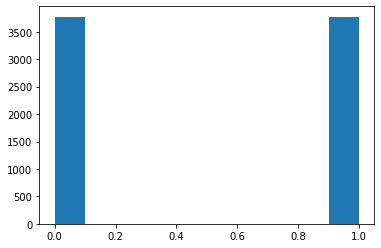

In [69]:
# print(X_train)
# print(X_train.shape[0])
# print(X_train.shape[1])
# print(X_train.shape[2])
print(X_train)
print('\n')
print(y_train)

plt.hist(y_train)

# badge in first column

In [70]:
print(X_train.shape)

(7550, 3, 251)


In [71]:
# drop badge right before we train the model:
    # have to iterate through both train and test and drop
        # X_train y_train, X_test, y_test
    

# drop badge from training data:
    # is it the first column??
# for i in range(len(y_train)):
#     for j in range(len(y_train[i])):
        
#     employee_slices[i] = employee_slices[i].drop(['badge'], axis=1)

X_train = X_train[:, :, 1:]
# y_train = y_train[1:]

X_test = X_test[:, :, 1:]
# y_test = y_test[1:]

print(X_train)
print('\n')
print('\n')
print(y_train)


# checking that types are the same:
print(X_train.shape)

[[[0. 1. 1. ... 0. 1. 0.]
  [0. 1. 1. ... 0. 1. 0.]
  [0. 1. 1. ... 0. 1. 0.]]

 [[0. 1. 1. ... 0. 1. 0.]
  [0. 1. 1. ... 0. 1. 0.]
  [0. 1. 1. ... 0. 1. 0.]]

 [[0. 1. 1. ... 0. 0. 0.]
  [0. 1. 1. ... 0. 0. 0.]
  [0. 1. 1. ... 0. 0. 0.]]

 ...

 [[0. 1. 1. ... 0. 1. 0.]
  [0. 1. 1. ... 0. 1. 0.]
  [0. 1. 1. ... 0. 1. 0.]]

 [[0. 1. 1. ... 0. 1. 0.]
  [0. 1. 1. ... 0. 1. 0.]
  [0. 1. 1. ... 0. 1. 0.]]

 [[0. 0. 1. ... 0. 0. 1.]
  [0. 0. 1. ... 0. 0. 1.]
  [0. 0. 1. ... 0. 0. 1.]]]




[1. 0. 1. ... 0. 1. 0.]
(7550, 3, 250)


In [72]:
loss = 'binary_crossentropy'

# if loss == 'sparse_categorical_crossentropy':
#     for i in range(len(y_test)):
#         if y_test[i][0] == 1:
#             y_test[i][0] = 0.99
    
#     for j in range(len(X_test)):
#         if X_test[j][0] == 1:
#             X_test[j][0] = 0.99


print('training model')
print('\n')

# Actually building the net:

# print(X_train.shape[0])
# print(X_train.shape[1])
# print(X_train.shape[2])

model = keras.Sequential()
model.add(keras.layers.LSTM(
  units=31,
    return_sequences = True,
  input_shape=(X_train.shape[1], X_train.shape[2])
))
# change return_sequences to true if adding additional LSTM layer

model.add(keras.layers.LSTM(units=750))
# model.add(keras.layers.LSTM(units=1500))
model.add(keras.layers.Dense(activation='sigmoid',units=1))
model.compile(
  loss= loss,
    # try categorical crossentropy
  optimizer=keras.optimizers.Adam(lr=0.0001),
  metrics=['accuracy']  
)

# class_weight= {0:10.,
#                1:1.}

history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=1,
    #class_weight=class_weight,
    verbose=1,
    shuffle=False
)

# try adding another LSTM layer - might increase accuracy - tried
# adjust loss and accuracy functiond - tried
# try weights with no upsampling - tried
    # try weightd with Upsampling - tried, no effet
# google ways to increase precision


training model


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/30
7550/7550 [==============================] - 744s 99ms/sample - loss: 0.6181 - acc: 0.6440
Epoch 2/30
7550/7550 [==============================] - 764s 101ms/sample - loss: 0.5653 - acc: 0.6992
Epoch 3/30
7550/7550 [==============================] - 708s 94ms/sample - loss: 0.5442 - acc: 0.7075
Epoch 4/30
7550/7550 [==============================] - 754s 100ms/sample - loss: 0.5329 - acc: 0.7125
Epoch 5/30
7550/7550 [==============================] - 773s 102ms/sample - loss: 0.5244 - acc: 0.7183
Epoch 6/30
7550/7550 [==============================] - 661s 88ms/sample - loss: 0.5166 - acc: 0.7228
Epoch 7/30
7550/7550 [==============================] - 711s 94ms/sample - loss: 0.5077 - acc: 0.7272
Epoch 8/30
7550/7550 [==============================] - 704s 93ms/sample - loss: 0.4965 - acc: 0.7315
Epoch 9/30
7550/7550 [======================

In [73]:
# print(model.metrics_names)

In [74]:
model.evaluate(X_test,y_test,verbose=2)
# second line of output is just (loss, accuracy) I believe

 - 1s - loss: 0.9961 - acc: 0.5493


[0.9960645549776884, 0.54933584]

In [75]:
# PREDICTION: Testing the results of our model:

## Predicting one value:

# emptyList = [0]
# emptyList[0] = X_test[0]

# emptyArray = np.array(emptyList)

# y_pred = model.predict(emptyArray)

#print(y_pred)


## Predicting from entire X_test:

y_pred3 = model.predict(X_test)

print(y_pred3)

# the probability is the probability that they will get fired in the next month from a three month segment

[[0.42536074]
 [0.42536074]
 [0.42536074]
 ...
 [0.03416946]
 [0.03416947]
 [0.03416947]]


In [76]:
## Predicting the results for the entire test dataset:

#y_pred2 = model.predict(X_test)
#print("y_pred2 is: ", y_pred2)

# A random predicted value in the dataset:

#print("y_pred2[32] is: ", y_pred2[32])


# compare y_test with the prediction from X_test in above cell:
#print(y_test)
#print(type(y_test[5]))
print(y_train)

[1. 0. 1. ... 0. 1. 0.]


In [77]:
# checking accuracy of model for each class, separately:

# Y_test = np.argmax(y_test) # Convert one-hot to index

y_pred4 = model.predict_classes(X_test)

print(classification_report(y_test, y_pred4))

# confusion matrix:
confusion_matrix(y_test, y_pred4, labels=[0,1])

# remember that X_test does not need to be balanced, only X_train
    # the fact that X_test isn't balanced doesn't affect our results at all
    

              precision    recall  f1-score   support

         0.0       0.91      0.55      0.68       939
         1.0       0.13      0.57      0.22       115

    accuracy                           0.55      1054
   macro avg       0.52      0.56      0.45      1054
weighted avg       0.83      0.55      0.63      1054



array([[513, 426],
       [ 49,  66]])

In [78]:
sum(y_pred4)
#print(len(y_pred4))

array([492], dtype=int32)

In [79]:
sum(y_test)

115.0

In [80]:
# summary of the model:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 3, 31)             34968     
_________________________________________________________________
lstm_1 (LSTM)                (None, 750)               2346000   
_________________________________________________________________
dense (Dense)                (None, 1)                 751       
Total params: 2,381,719
Trainable params: 2,381,719
Non-trainable params: 0
_________________________________________________________________
